In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport utils.backtest
%aimport solvers.meanvariance
%aimport solvers.DRmeanvariance
%aimport solvers.rolling
%aimport solvers.simple

In [3]:
import tushare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import sys

First we consider a distributionally robust (DR) mean-variance optimization model without any capital or long-short constraint. Using the cost function $c(u,w) = \|u-w\|^2_q$, and define $D_c(\mathbb{P},\mathbb{Q})$ as the corresponding optimal transport distance. The DR optimization problem is given by:
$$
\min_{\theta}\sup_{\mathbb{P}:D_c(\mathbb{P},\mathbb{P}_0)\leq \delta} \sqrt{\theta^\top\rm{Cov}_{\mathbb{P}}(R)\theta} 
- \lambda \theta^\top\rm{E}_{\mathbb{P}}(R)
$$
where $\mathbb{P}_0$ is a reference probability measure of the random vector $R$. Applying the standard strong duality argument, we are able to derive the equivalent problem as: 
$$
\min_{\theta} \sqrt{\theta^\top\rm{Cov}_{\mathbb{P}_0}(R)\theta} 
- \lambda \theta^\top\rm{E}_{\mathbb{P}_0}(R)
+ \sqrt{1+\lambda^2}\cdot\sqrt{\delta}\|\theta\|_p
$$
**Technical Note: $\sqrt{\theta^\top\rm{Cov}_{\mathbb{P}_0}(R)\theta}$ and $\|\theta\|_p$ can be modelled using the power cone.**

Conduct matrix decomposition such that $\rm{Cov}_{\mathbb{P}_0}(R) = F^\top F$, so that $\sqrt{\theta^\top\rm{Cov}_{\mathbb{P}_0}(R)\theta} = \|F\theta\|_2$, using

    eigval, eigvecs = np.linalg.eig(cov)
    F = np.diag(np.sqrt(eigval)) @ eigvecs.T

The implementation of the above model can be found in **solvers.DRmeanvariance.py:**

In [4]:
SZ_code_list = pd.read_pickle('./SZ_code_list.pkl')
SH_code_list = pd.read_pickle('./SH_code_list.pkl')
trading_dates = pd.read_pickle('./trading_dates.pkl')
total_code_list = pd.concat([SZ_code_list, SH_code_list])
total_stock_num = len(total_code_list)
sample_stock_num = 50

In [5]:
ts_code_generator = np.random.RandomState(42)
sampled_ts_codes = ts_code_generator.choice(total_code_list, size = sample_stock_num, replace = False)
sampled_mean_vec, sampled_cov_mat = utils.debughelper.get_sample_mean_cov(sampled_ts_codes, integer_id = 1000)

In [5]:
%%timeit
theta = solvers.DRmeanvariance.DR_mean_variance_long_only_opt_cvx_kernel(
    sampled_cov_mat,
    sampled_mean_vec, 
    reg_params = 1, 
    delta = 0.1, 
    p = 2
)

31.1 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit
theta_mosek = solvers.DRmeanvariance.DR_mean_variance_long_only_opt_mosek_kernel_p2(
    sampled_cov_mat,
    sampled_mean_vec, 
    reg_params = 1, 
    delta = 0.1, 
    p = 2
)

16.3 ms ± 918 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
PnL_table = utils.backtest.resample_experiments(
    exp_num = 50, 
    sample_stock_num = 20, 
    solver = solvers.DRmeanvariance.DR_mean_variance_long_only_opt_mosek_kernel_p2, 
    reg_params = 1, 
    delta = 0.5, 
    p = 2
)

In [8]:
PnL_table = utils.backtest.resample_experiments(
    exp_num = 50, 
    sample_stock_num = 20, 
    solver = solvers.simple.equal_weight, 
)

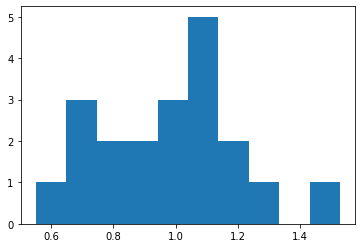

In [26]:
sharpe_func = lambda x: np.sqrt(252)*x.mean()/x.std()
plt.hist(np.array(list(map(sharpe_func, PnL_list))))
plt.show()

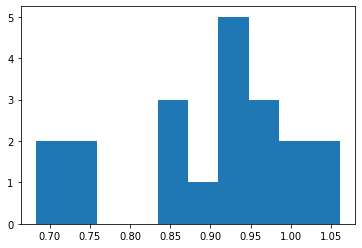

In [31]:
sharpe_func = lambda x: np.sqrt(252)*x.mean()/x.std()
plt.hist(np.array(list(map(sharpe_func, PnL_list))))
plt.show()

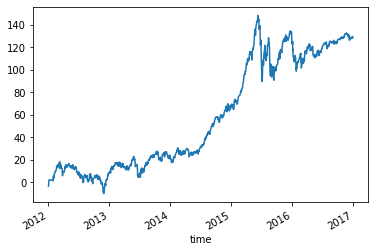

In [42]:
PnL_table.mean(axis = 1).cumsum().plot()

In [ ]:
=